# 1.Supuestos iniciales del ejercicicio

Al simular un gran número de escenarios con estos parámetros variables, el código permite:

*  Entender el rango de posibles resultados para métricas financieras cruciales como el Valor Actual Neto (VAN), la Tasa Interna de Retorno (TIR) y el Período de Recuperación de la Inversión (Payback).
*  Evaluar el riesgo asociado al proyecto al observar la distribución de estos indicadores.
*  Tomar decisiones de inversión más informadas, considerando la incertidumbre inherente a los proyectos financieros.

En síntesis, es una herramienta poderosa para el análisis de sensibilidad y la planificación estratégica en el ámbito de las finanzas.

Como en el ejercicio anterior, la siguiente tabla muestra los supuestos y su nomenclatura, que servirán como parámetros del ejercicio de la evaluación de inversión o proyecto.

| variable | símbolo definición | comentario |
|--|--|--|
| Inversión inicial| $M$ | se hace en el tiempo 0 |
| Plazo | $P$ | horizonte de evaluación|
| Ticket | $p$ | precio promedio unitario|
| Venta inicial | $V_0$_$sim$ |  venta inicial mensual, que sigue una distribución probabilistica teórica |
| Crecimiento (flujo) | $g$_$values$ | tasa de crecimiento mensual, que sigue una distribución probabilistica teórica|
| Costos variables| $c$_$sim$ | pueden ser insumos, materia prima y que representan un porcentaje de la venta, que sigue una distribución probabilistica teórica|
| Gasto fijo |$G$_$sim$| gastos fijos mensuales, como Arriendo, dividendo, etc, que sigue una distribución probabilistica teórica|
| Impuesto |$t$| impuestos a las empresas, como por ejemplo 20% de los régimen chileno|
| Tasa descuento |$tasa$_$descuento$| impuestos a las empresas, como por ejemplo 8% de los régimen chileno, útil para el cálculo del valor actual neto|
| N° simulaciones |$N$_$simulaciones$| número de simulaciones que serán evaluadas|
| Tasa baseline |$tasa$_$baseline$| tasa útil para la comparación en una inversión de riesgo acotado|

Luego, el valor de cada uno de los parámetros definidos es:

*   $M = \$45.000.000$
*   $P = 48$
*   $p = \$5.000$ (por ticket)
*   $V_0$_$sim \sim N(1200, 380)$ clientes diarios
*   $g$_$sim \sim N(0.08, 0.75)$ mensual
*   $c$_$sim \sim N(0.0023, 0.005)$ (costos variables)
*   $G$_$sim \sim N(4000000, 400000)$ mensuales
*   $t = 20\%$
*   $tasa$_$descuento = 8\%$
*   $N$_$simulaciones = 10.000$
*   $tasa$_$baseline = 12\%$

Estos valores serán asignados en este ejercicio pero pueden ser modificados en virtud de la naturaleza de la inversión.

# 2.Creación del espacio necesario.

Para ejecutar el ejercicio de evaluación multi-escenario de una inversión, es necesario hacer la llamada o instalaciones de las librerias a utilizar.

## 2.1 Librerías de tratamiento de datos y visualización

In [1]:
%pip install numpy-financial

In [2]:
import numpy as np
import pandas as pd
from numpy_financial import irr, npv
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

## 2.2 Se declaran los parámetros del ejercicio

In [26]:
M = 45000000
P = 48
p = 5000
t = 0.2
tasa_descuento = 0.08
N_simulaciones = 10000
tasa_baseline = 0.12

Adicionalmente se incorporan las condiciones para $N$ simulaciones. Por simplicidad se opta por distribuciones normales, pero estas pueden cambiar según la naturaleza de la inversión.

In [27]:
np.random.seed(42)

g_sim = np.clip(np.random.normal(0.08, 0.75, N_simulaciones), 0.01, 0.04)
#g_sim = np.random.normal(0.08, 0.75, N_simulaciones)
c_sim = np.random.normal(0.0023, 0.005, N_simulaciones)
G_sim = np.random.normal(4000000, 400000, N_simulaciones)
V0_sim = np.random.normal(40 * 30, 380, N_simulaciones)

# 3.Desarrollo

A continuación se desarrolla, simula múltiples escenarios de un proyecto o inversión financiera para evaluar su viabilidad bajo diferentes condiciones vía simulaciones en un *cuasi Monte Carlo*.

In [28]:
results = []

for i in range(N_simulaciones):
    g, c, G, V0 = g_sim[i], c_sim[i], G_sim[i], V0_sim[i]

    flujo_mensual = [-M]
    flujo_acumulado = [-M]

    for n in range(1, P+1):
        ventas = p * V0 * (1 + g) ** (n-1)
        costos_var = c * ventas
        utilidad = ventas - costos_var - G
        impuesto = t * utilidad if utilidad > 0 else 0
        flujo = utilidad - impuesto
        flujo_mensual.append(flujo)
        flujo_acumulado.append(flujo_acumulado[-1] + flujo)

    van = npv(tasa_descuento, flujo_mensual)
    tir = irr(flujo_mensual)

    payback = next((j for j, ac in enumerate(flujo_acumulado) if ac >= 0), np.nan)
    pi = (van + M) / M
    van_payback = van / payback if payback and payback != 0 else np.nan

    results.append({
        'VAN': van,
        'TIR': tir,
        'Payback': payback,
        'PI': pi,
        'VAN/Payback': van_payback
    })

df = pd.DataFrame(results)

# 4.Confección resultados

Desde ahora, se puede ir generando el DataFrame para posteriormente ver los resultados.

## 4.1 Indicadores de proyecto

Para cada simulación se calcularon el VAN y TIR, para luego calcular el tiempo de recuperación o Payback.

### 4.1.1 VAN, TIR, Payback

In [29]:
def percentiles(variable):
    return np.percentile(df[variable].dropna(), [10, 50, 90])

for var in ['VAN', 'TIR', 'Payback', 'PI', 'VAN/Payback']:
    p10, p50, p90 = percentiles(var)
    print(f"\n{var}:")
    print(f" P10: {p10:.2f},  P50 (mediana): {p50:.2f},  P90: {p90:.2f}")


VAN:
 P10: -38870681.47,  P50 (mediana): -3497734.55,  P90: 44009400.90

TIR:
 P10: 0.01,  P50 (mediana): 0.08,  P90: 0.13

Payback:
 P10: 10.00,  P50 (mediana): 17.00,  P90: 32.00

PI:
 P10: 0.14,  P50 (mediana): 0.92,  P90: 1.98

VAN/Payback:
 P10: -923372.53,  P50 (mediana): -33010.15,  P90: 4225446.92


### 4.1.2 VaR, ES

El valor en riesgo (Value at Risk: VaR) es una medida utilizada para cuantificar el riesgo financiero de una cartera o inversión. Se calcula como el cuantil de máxima tolerancia para no generar pérdidas, según cierto nivel de confianza.

$VaR_{1-\alpha} = \inf_{k \in\mathbb{R}}\{k: Pr(X \leq k) \geq 1- \alpha\}$

El Expected Shortfall (ES), o Déficit Esperado, es una medida de riesgo financiero que indica la pérdida promedio esperada en una inversión, dado que se ha superado un cierto nivel de pérdida (VaR). En otras palabras, es el promedio de las pérdidas más allá del valor en riesgo (VaR) en un nivel de confianza dado.

$ES_{1-\alpha} = \mathbb{E}[X|X>VaR_{1-\alpha}]$

In [30]:
var_95 = np.percentile(df['VAN'], 5)
es_95 = df[df['VAN'] <= var_95]['VAN'].mean()

print(f"\nValue at Risk (VaR 95%): {var_95:,.2f}")
print(f"Expected Shortfall (ES 95%): {es_95:,.2f}")
print(f"\nValue at Risk (%): {var_95/M*100:.2f}%")
print(f"\nExpected Shortfall (%): {es_95/M*100:.2f}%")


Value at Risk (VaR 95%): -48,127,174.29
Expected Shortfall (ES 95%): -61,600,700.75

Value at Risk (%): -106.95%

Expected Shortfall (%): -136.89%


## 4.2 Criterios de éxito

Se definen criterios de éxito, estos son propios del análisis en la evaluación de proyectos, se tiene que considerar las condiciones de lo/as inversionistas y estas también pueden estar sujetas a una sucesión de valores.

### 4.2.1 Criterio rigido

In [31]:
criterio = (
    (df['VAN'] > 0) &
    (df['TIR'] > 0.12) &
    (df['Payback'] <= 36) &
    (df['PI'] > 1)
)

prob_exito = criterio.mean()

print(f"\nProbabilidad de éxito global (cumple los 4 criterios simultáneamente): {prob_exito*100:.2f}%")


Probabilidad de éxito global (cumple los 4 criterios simultáneamente): 12.98%


### 4.2.2 Criterio flexible

In [32]:
criterio = (
    (df['VAN'] > 0) |
    (df['TIR'] > 0.12) |
    (df['Payback'] <= 36) |
    (df['PI'] > 1)
)

prob_exito = criterio.mean()

print(f"\nProbabilidad de éxito global (cumple al menos uno de los 4 criterios): {prob_exito*100:.2f}%")


Probabilidad de éxito global (cumple al menos uno de los 4 criterios): 86.78%


### 4.2.3 Criterio intermedio

In [33]:
criterio = (
    (df['VAN'] > 0) &
    (df['TIR'] > 0.12) |
    ( (df['Payback'] <= 36) |
      (df['PI'] > 1)
    )
)

prob_exito = criterio.mean()

print(f"\nProbabilidad de éxito global (cumple VAN y TIR o Payback con PI): {prob_exito*100:.2f}%")


Probabilidad de éxito global (cumple VAN y TIR o Payback con PI): 86.78%


## 4.3 Visualización de indicadores

<Figure size 1600x500 with 0 Axes>

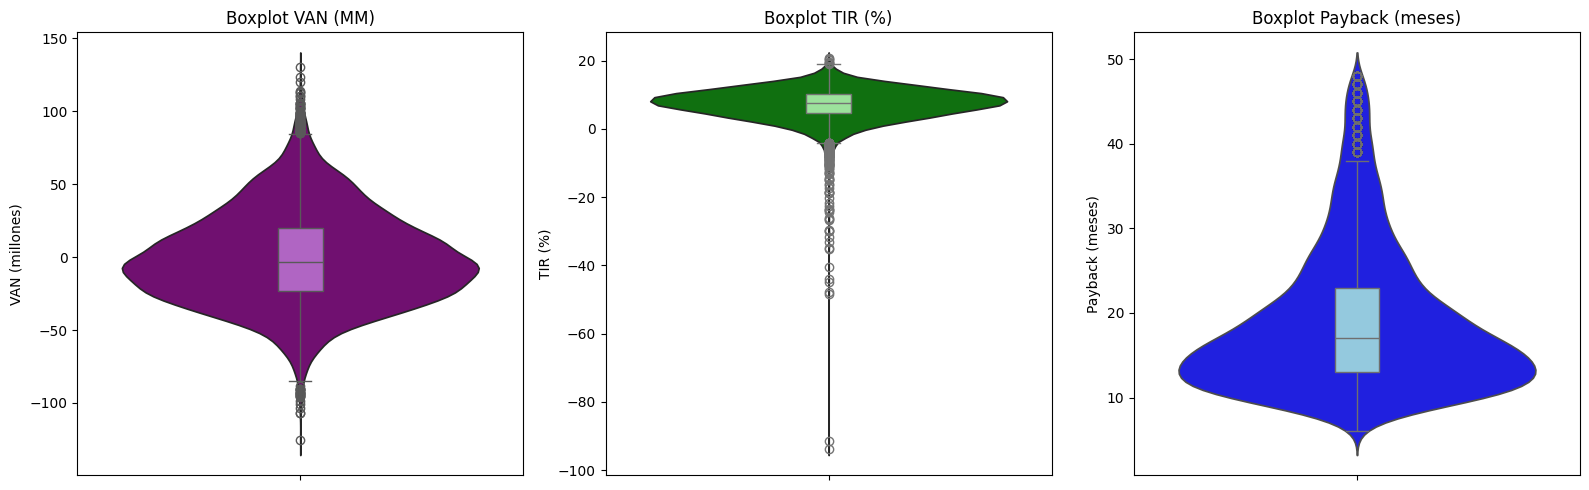

In [34]:
plt.figure(figsize=(16, 5))
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

plt.subplot(1,3,1)
ax = sns.violinplot(y=df['VAN']/1e6, color='purple', inner = None)
sns.boxplot(y=df['VAN']/1e6, color='mediumorchid', width=0.1, boxprops={'zorder': 2}, ax=ax)
plt.title('Boxplot VAN (MM)')
plt.ylabel("VAN (millones)")

plt.subplot(1,3,2)
ax = sns.violinplot(y=df['TIR']*100, color='green', inner = None)
sns.boxplot(y=df['TIR']*100, color='lightgreen', width=0.1, boxprops={'zorder': 2}, ax=ax)
plt.title('Boxplot TIR (%)')
plt.ylabel("TIR (%)")

plt.subplot(1,3,3)
ax = sns.violinplot(y=df['Payback'], color='blue', inner = None)
sns.boxplot(y=df['Payback'], color='skyblue', width=0.1, boxprops={'zorder': 2}, ax=ax)
plt.title('Boxplot Payback (meses)')
plt.ylabel("Payback (meses)")

plt.tight_layout()
plt.show()

In [12]:
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

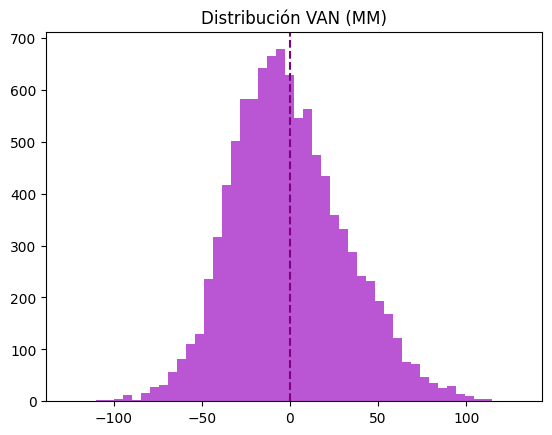

In [35]:
plt.hist(df['VAN']/1e6, bins=50, color='mediumorchid')
plt.title('Distribución VAN (MM)')
plt.axvline(0, color='purple', linestyle='--')

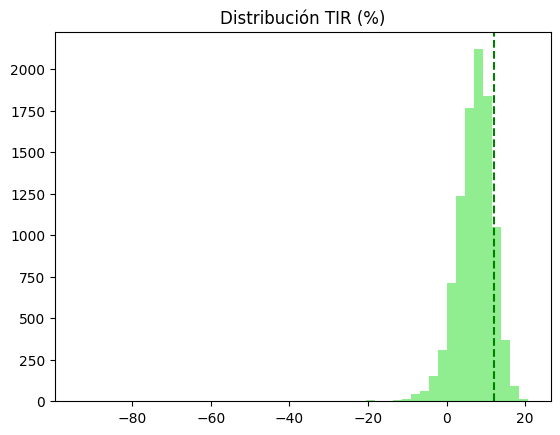

In [36]:
plt.hist(df['TIR']*100, bins=50, color='lightgreen')
plt.title('Distribución TIR (%)')
plt.axvline(tasa_baseline*100, color='green', linestyle='--')

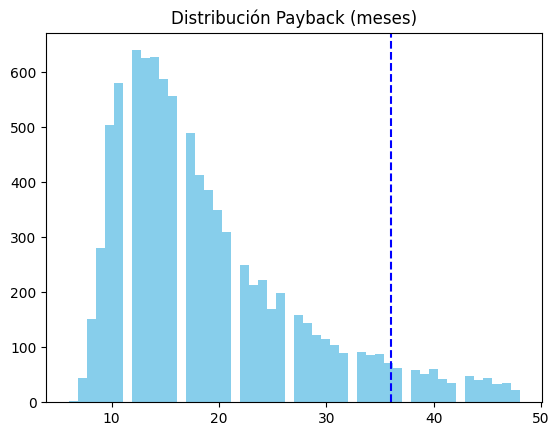

In [37]:
plt.hist(df['Payback'], bins=50, color='skyblue')
plt.title('Distribución Payback (meses)')
plt.axvline(36, color='blue', linestyle='--')

In [38]:
Pr_VAN0 = (df['VAN']> 0).mean()

print(f"\nProbabilidad de VAN positivo: {Pr_VAN0*100:.2f}%")


Probabilidad de VAN positivo: 45.45%


Podría establecerse una regla según los valores que se cacularon anteriormente:

Indicador de proyecto | Comparación | Interpretación
----|----|----
$Pr\{TIR>$ $tasa$_$baseline \}$|$\geq80\%$| La inversión tiene un retorno superior a una tasa objetivo de riesgo.
$Pr$$\{VAN>0\}$ | $\geq 85\%$ | La probabilidad de que el VAN sea superior a 0.
$VaR_{95\%} /M$ | $\geq -10\%$ | El valor en riesgo del VAN al $95\%$ respecto a la inversión.
$ES_{95\%} /M$ | $\geq -20\%$ | La pérdida esperada dado el peor escenario al $95\%$ respecto a la inversión.

En general se puede decir que un VaR y un ES mientras más cercanos a números positivos, denota una distribución más positiva, en general.